In [199]:
import numpy as np
import math
import matplotlib.pyplot as plt

pi = math.pi
inf = math.inf

In [200]:
# calculate impedance of an L or C element on the given frequency
# if the input value is positive, then Z is calculated for a "value" valued inductance [H]
# if the input value is negative, then Z is calculated for a "-value" valued capacitance [F]
def Impedance(freq, value):
    if(value >= 0 or value == inf): # value is inductance in [Henry]
        return 0+freq*1j*2*pi*value
    else: # -1*value is capacitance in [Farad]
        return -1j*1/(freq*2*pi*(-value))

# calculate parallel impedance of Z1 and Z2,
# considering possible 0 and infinite values
def Parallel(Z1, Z2):
    if(Z1==0.0 or Z2==0.0):
        return 0.0
    elif(abs(Z1)==inf or abs(Z2) == inf):
        if(abs(Z1)==inf and abs(Z2) == inf):
            return inf
        else:
            if(abs(Z1)==inf):
                return Z2
            else:
                return Z1
    else:
        return Z1*Z2/(Z1+Z2)

def YfromZ(Z):
    if(Z==0):
        return inf
    else:
        return 1/Z

#def SMatrixFromY(Y):
    

In [201]:
class Spec:
    def __init__(self, starts, ends, limits, directions):
        # starts of pass- or stopbands in Hz
        self.starts = starts
        # ends of start- or stopbands in Hz
        self.ends = ends
        # pass- or stopband threshold values
        self.limits = limits
        # pass- or stopbands? possible values: "pass" or "stop" strings
        self.directions = directions

    #def cost(self, types, values):
    def cost(self, n=10, plot=False, par11=inf, par12=inf, ser11=0.0, ser12=0.0, par21=inf, par22=inf, ser21=0.0, ser22=0.0, par31=inf, par32=inf, ser31=0.0, ser32=0.0):
        """Parameters define a ladder structure,
        where each series or parallel element consists of
        two discrete, ideal L or C components in parallel
        with each other. Default values define a perfect
        all-pass filter. In the function parameters, "parXY" means
        the value of the Y-th sub-component of the X-th parallel
        element. Similarly, "serXY" means the value of the Y-th
        sub-component of the X-th series element. The ladder starts
        with a parallel element."""
        values = [par11, par12, ser11, ser12, par21, par22, ser21, ser22, par31, par32, ser31, ser32]
        nval = len(values)
        nladder = int(nval/4)
        minf = (min(self.starts))
        maxf = (max(self.ends))
        # frequency axis sample points (log spacing)
        faxis = []
        # no. of frequency sample points
        #n = 10
        factor = (maxf/minf)**((1/n))
        for i in range(n+1):
            faxis.append(minf*factor**(i))
        # reference impedance in Ohm
        Z0 = 50
        Y0 = 1/Z0
        # array of overall S21 values at the
        # frequency sample points
        S21 = []
        #TODO: process arguments in a new way
        #process 1 parallel and 1 series element:
        for f in faxis:
            S = np.matrix([[0,1],[1,0]])
            for l in range(nladder):
                # admittance of the two parallel components together from the current step of the ladder
                Y = YfromZ(Parallel(Impedance(f, values[l+0]), Impedance(f, values[l+1])))
                if(abs(Y) == inf):
                    mPar = np.matrix([[0, 1],[1, 0]])
                else:
                    mPar = np.matrix([[-Y, 2*Y0],[2*Y0, -Y]])/(Y+2*Y0)
                Z = Parallel(Impedance(f, values[l+2]), Impedance(f, values[l+3]))
                if(abs(Z) == inf):
                    mSer = np.matrix([[1, 0],[0, 1]])
                else:
                    mSer = np.matrix([[Z, 2*Z0],[2*Z0, Z]])/(Z+2*Z0)
                S = S*mPar*mSer
            S21.append(abs(S.item(0,1)))
        if(plot):
            plt.loglog(faxis, S21)
            plt.show()
        cost = 0
        # number of freq points in the regions where the S21 is specified
        ncost = 0
        for i in range(len(self.starts)):
            for j in range(len(faxis)):
                if faxis[j]>self.starts[i] and faxis[j]<self.ends[i]:
                    ncost = ncost + 1
                    if self.directions[i] == "pass":
                        cost += max(0, 1-S21[j]/self.limits[i])
                    else: # "stop"
                        cost += max(0, S21[j]/self.limits[i]-1)
        return cost/ncost

In [202]:
starts = [1, 100, 10000]
ends = [10, 1000, 100000]
limits = [0.1, 0.9, 0.1]
directions = ["stop", "pass", "stop"]
spec = Spec(starts, ends, limits, directions)

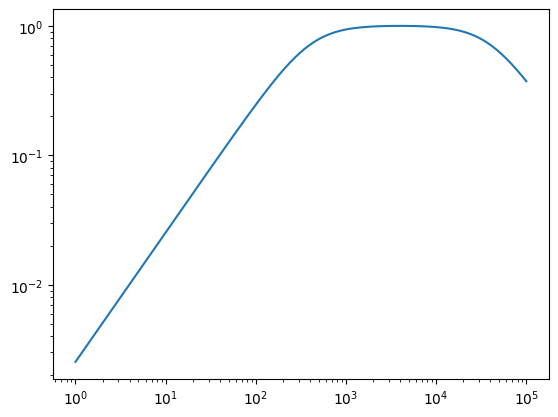

2.269548248296577

In [206]:
spec.cost(plot=True, n=1000, par11=1e-4, ser11=1e-2)

In [ ]:
for i in range(10,100000,10):
    